In [1]:
import os
os.getcwd()
os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

<Figure size 1152x1152 with 0 Axes>

In [2]:
def eval_sq(kappa, epsilon, chain, qq, n_sample = 20, n_merge = 4, n_choice = 1e8, rayleigh=False):
    ## generate spectra of three different grids
    S_q_list = []
    S_q_2D_list = []

    chain_Cc_list = []
    for i, grid in enumerate(['SC','RB','RT']):
        S_q_i = np.zeros_like(qq)
        qq_2D = np.concatenate((-np.flip(qq), np.array([0.0]), qq))
        S_q_2D_i = np.zeros([len(qq_2D),len(qq_2D),3])
        for j in trange(n_sample):
            # chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
            chain.grid = grid
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.f = 0.0
            chain.kappa = kappa
            chain.epsilon = epsilon


            chain.chain_grid()
            N = chain.N
            chain_box = chain.box
            
            chain.scatter_direct_aniso(qq,n_merge=n_merge, n_choice=n_choice)
            S_q_i = S_q_i + chain.S_q
            S_q_2D_i = S_q_2D_i + chain.S_q_2D

        #     E_j = np.sum(chain.E_list)
        #     E_total+=E_j
        # E_total = E_total/n_sample
        # print(E_total)

        qq = chain.qq    
        qq_2D = chain.qq_2D
        S_q_list.append(S_q_i/n_sample) # Append the S(Q) of given grid type
        S_q_2D_list.append(S_q_2D_i/n_sample) # Append the 2D S(Q) of given grid type

    ## Rayleigh chain
    if rayleigh:
        S_q_i = np.zeros_like(qq)
        qq_2D = np.concatenate((-np.flip(qq), np.array([0.0]), qq))
        S_q_2D_i = np.zeros([len(qq_2D),len(qq_2D),3])
        chain.a = kappa
        for j in trange(n_sample):
            chain.chain()
            chain.scatter_direct_aniso(qq,n_merge=n_merge, n_choice=n_choice)
            S_q_i = S_q_i + chain.S_q
            S_q_2D_i = S_q_2D_i + chain.S_q_2D
        S_q_list.append(S_q_i/n_sample) # Append the S(Q) of given grid type
        S_q_2D_list.append(S_q_2D_i/n_sample) # Append the 2D S(Q) of given grid type

    return np.array(S_q_list), np.array(S_q_2D_list)

In [3]:
## Chain parameters
# Coordinate of C atoms in each unit
# unit_C = load('b_c.dat')';
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 5000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 1
chain.d_exc = 0.1
chain.f = 0.0

kappa_list = np.array([50])
epsilon_list = [0]

parameters_list = []
S_q_list_param = []
S_q_2D_list_param = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])
        qq = 2*np.pi*(np.linspace(4,100,25))/N_backbone

        # Chain stiffness
        chain.kappa = kappa
        chain.epsilon = epsilon

        S_q_list_grid, S_q_2D_list_grid = eval_sq(kappa, epsilon, chain, qq, 
                                                  n_sample = 1, n_merge = 8, rayleigh=True)
        S_q_list_param.append(S_q_list_grid)
        S_q_2D_list_param.append(S_q_2D_list_grid)

  0%|          | 0/1 [00:00<?, ?it/s]

625 beads used to calculate S(q)
23 plane
13 plane
12 plane


  0%|          | 0/1 [00:00<?, ?it/s]

625 beads used to calculate S(q)
23 plane
13 plane
12 plane


  0%|          | 0/1 [00:00<?, ?it/s]

625 beads used to calculate S(q)
23 plane
13 plane
12 plane


  0%|          | 0/1 [00:00<?, ?it/s]

625 beads used to calculate S(q)
23 plane
13 plane
12 plane


100%|██████████| 1/1 [02:35<00:00, 155.50s/it]


[50, 0]


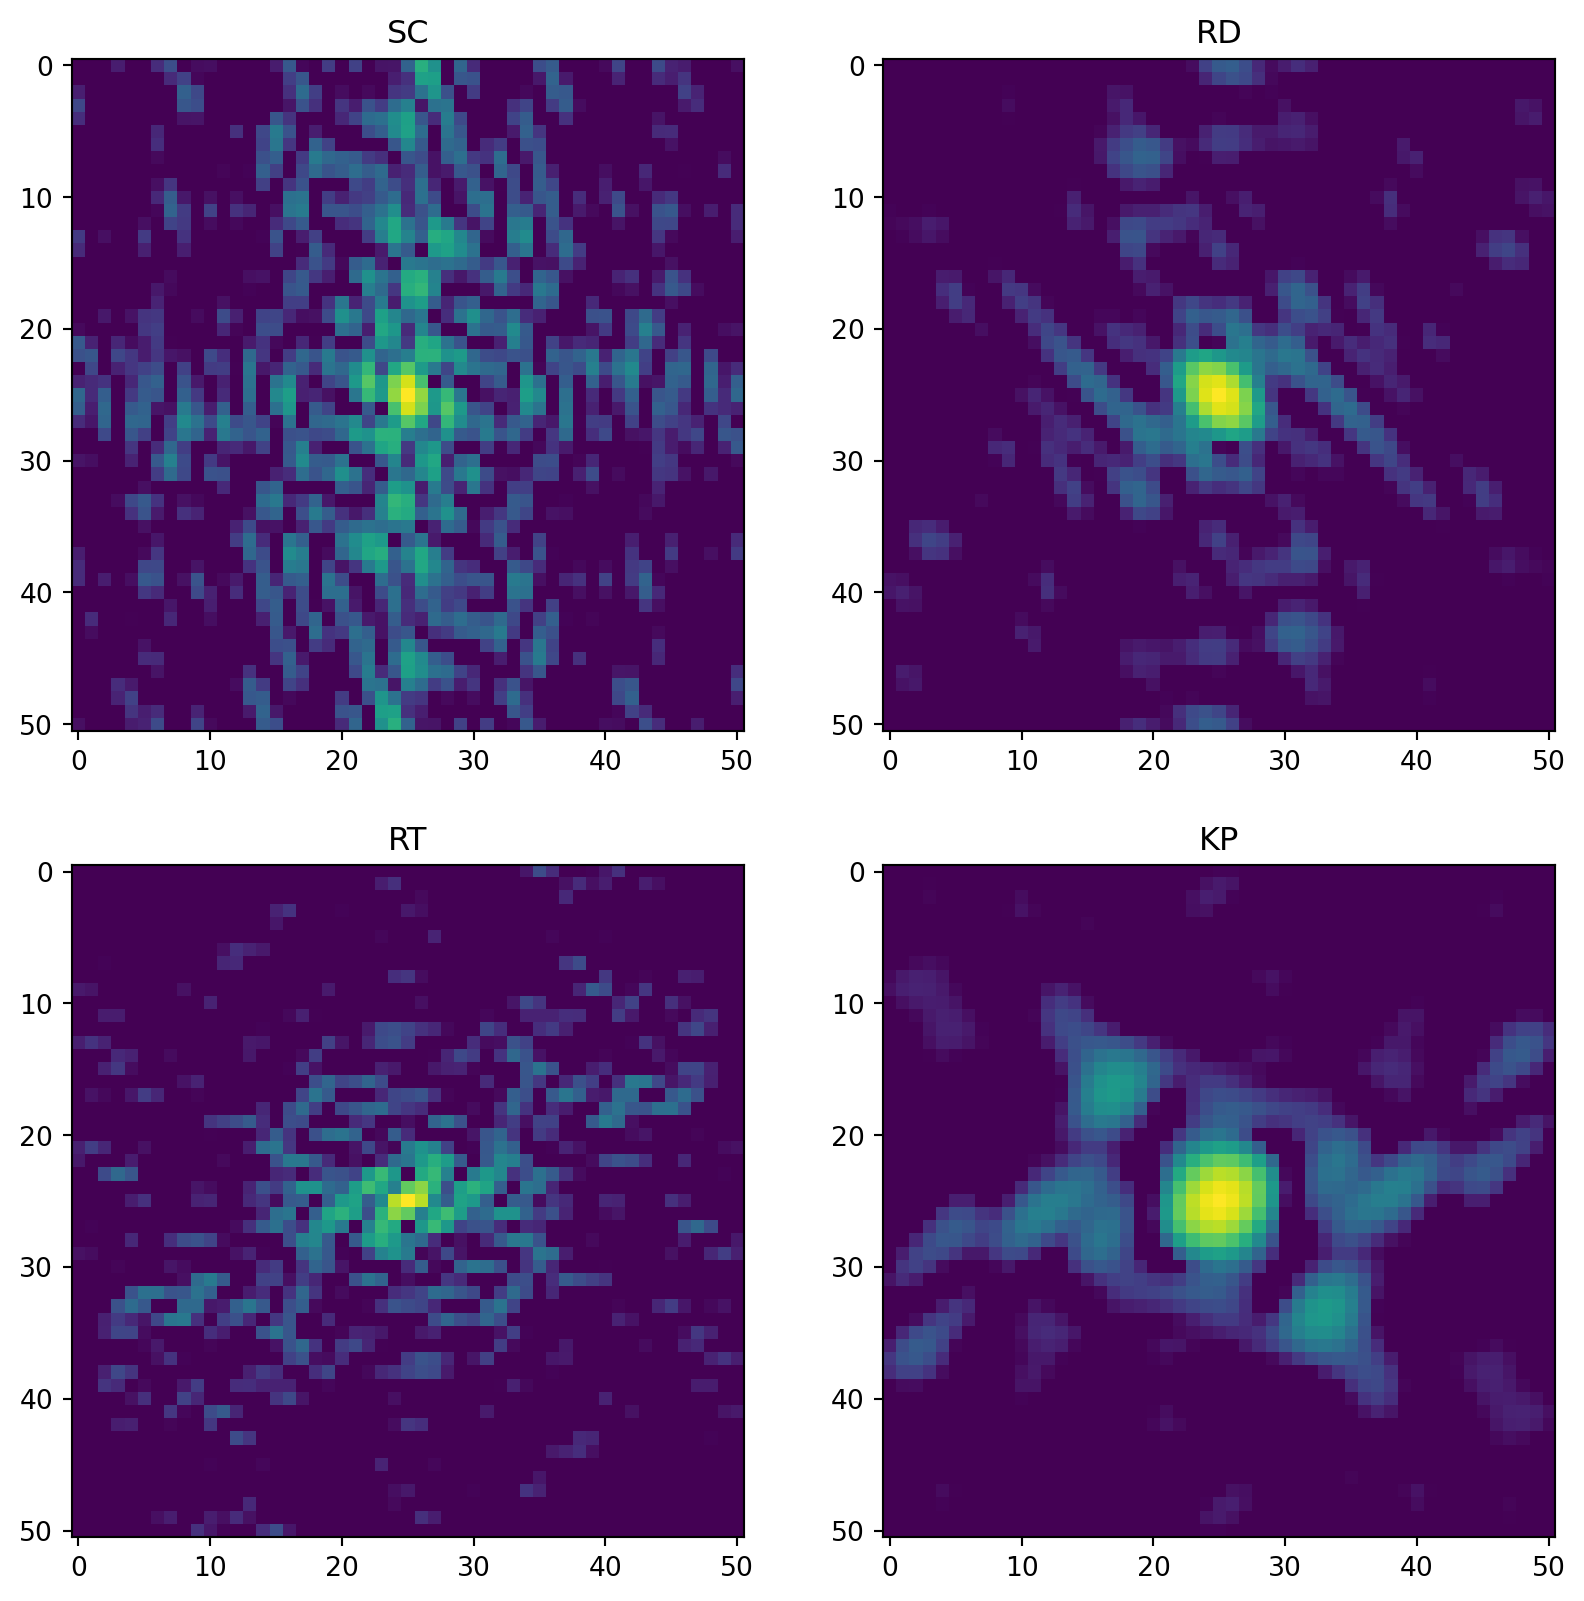

In [4]:
fig = plt.figure(figsize=(10, 10),dpi=192)
for i, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)

    S_q_2D_list = S_q_2D_list_param[i]

    for j, grid in enumerate(['SC','RD','RT']):
        ax = fig.add_subplot(2,2,j+1)
        ax.imshow(np.log(S_q_2D_list[j,:,:,1]), vmax=0,vmin=-10)
        ax.set_title(grid)

    ax = fig.add_subplot(2,2,4)
    ax.set_title('KP')
    ax.imshow(np.log(S_q_2D_list[3,:,:,1]), vmax=0,vmin=-10)


[50, 0]


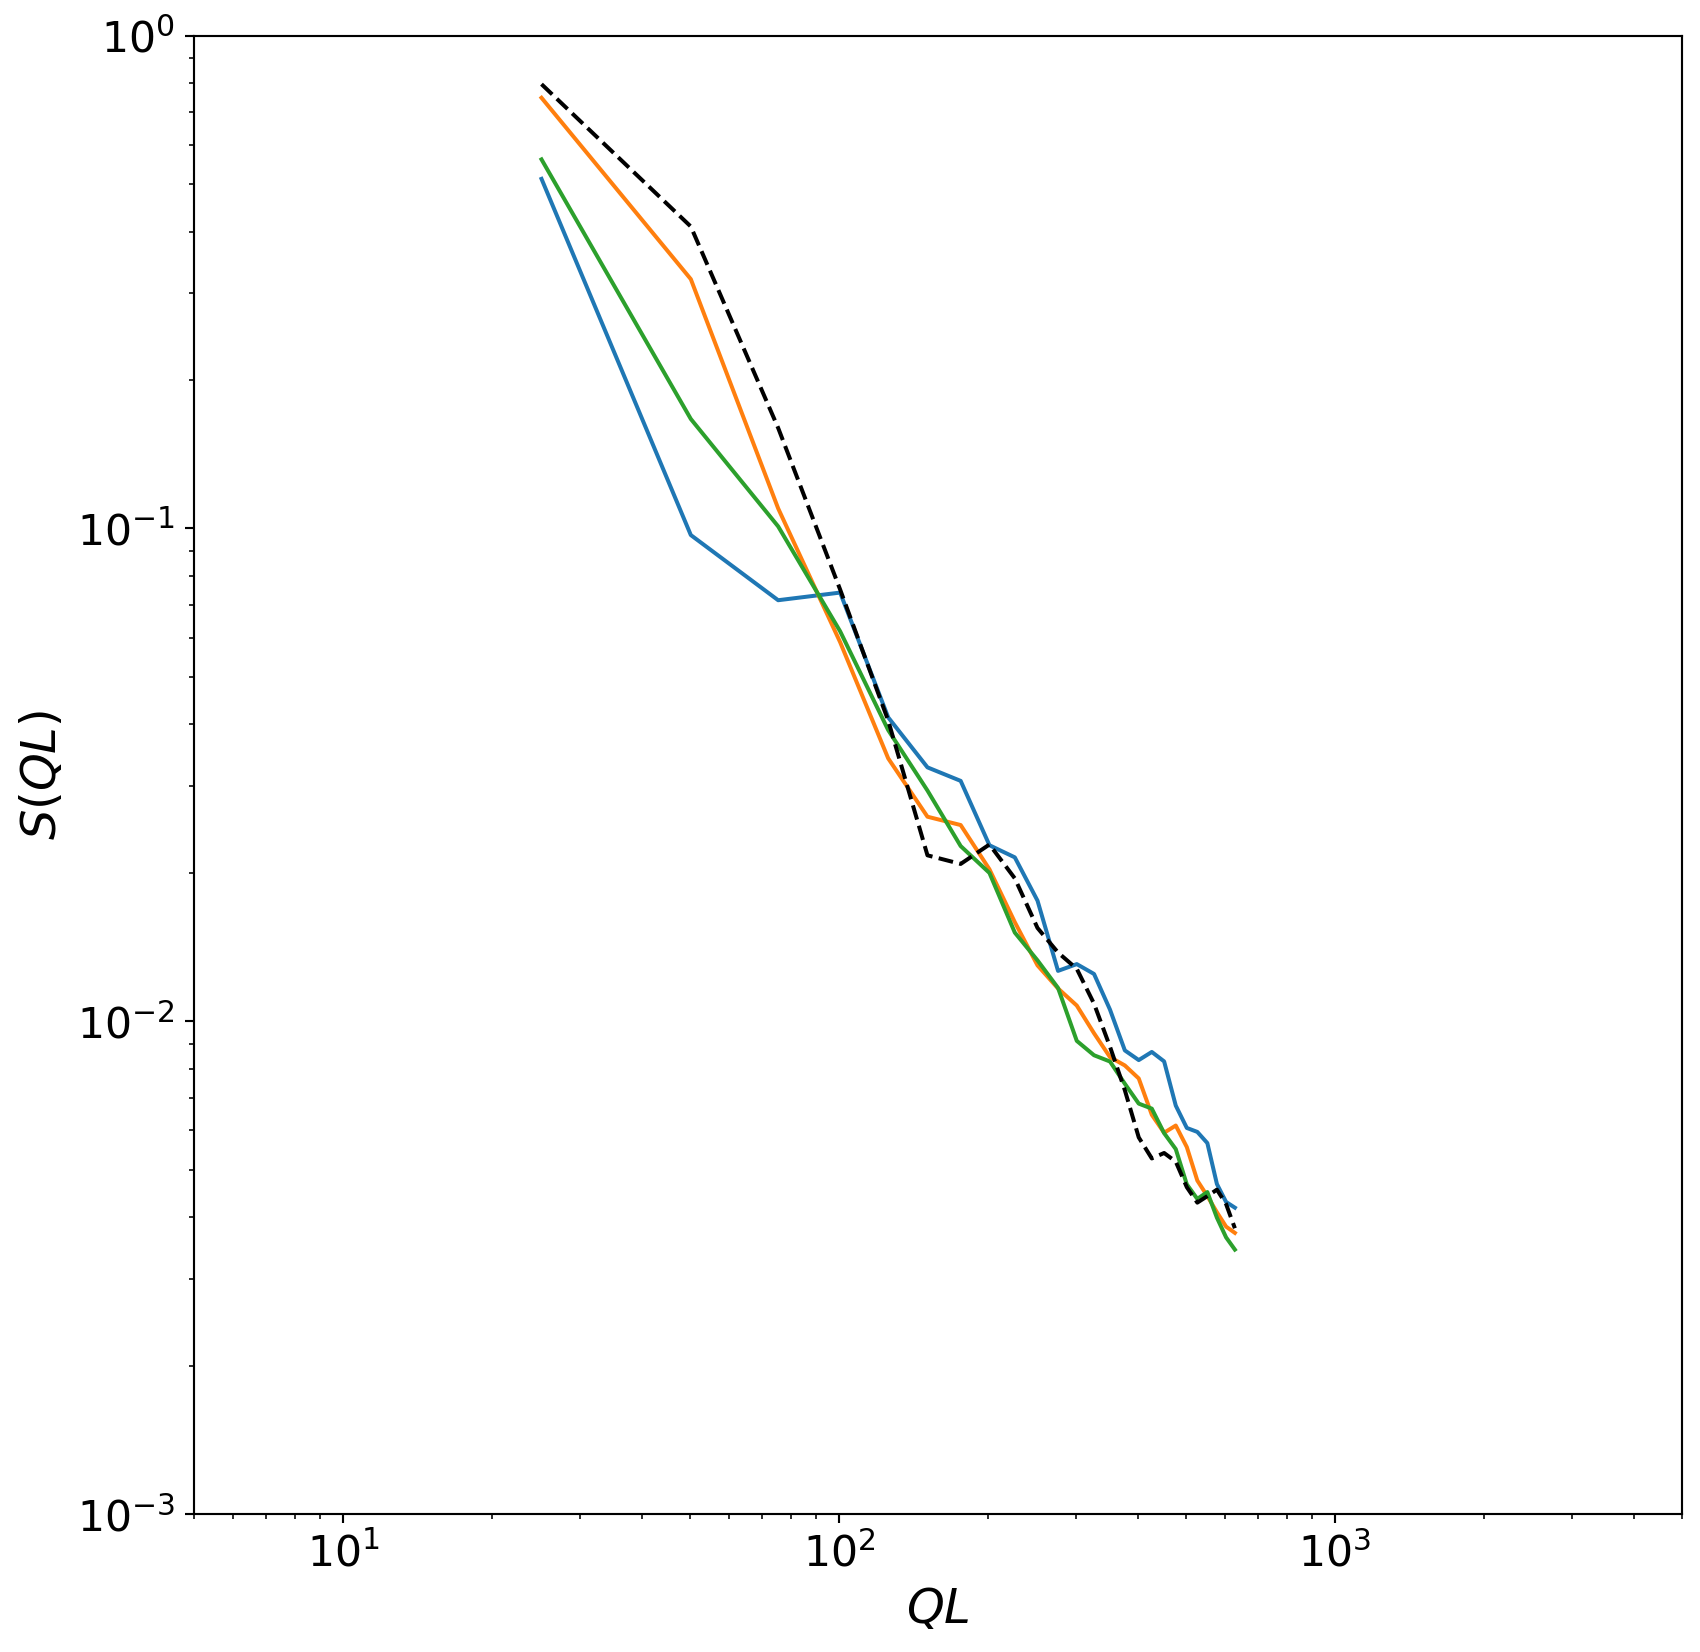

In [5]:
fig = plt.figure(figsize=(10, 10),dpi=192)
for i, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)

    S_q_list = S_q_list_param[i]

    ax = fig.add_subplot(1,1,1)
    for j, grid in enumerate(['SC','RD','RT']):
        
        ax.plot(qq*N_backbone, S_q_list[j], label=grid)

    ax.plot(qq*N_backbone, S_q_list[3], '--k', label='KP')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([5,5e3])
    ax.set_ylim([1e-3,1])
    ax.set_xlabel(r'$QL$',fontsize=18)
    ax.set_ylabel(r'$S(QL)$',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)


In [6]:
S_q_list_param[0]

array([[0.51193728, 0.09692267, 0.07148029, 0.07407691, 0.04135039,
        0.03273534, 0.03073032, 0.02274968, 0.02149826, 0.01756111,
        0.01264872, 0.01305582, 0.01246789, 0.01055521, 0.00872316,
        0.00833707, 0.00866056, 0.00828631, 0.00674047, 0.00607187,
        0.00596056, 0.00565716, 0.0046715 , 0.00429642, 0.00418359],
       [0.74772651, 0.32041054, 0.10977419, 0.05876365, 0.03414037,
        0.02599441, 0.02500151, 0.02033422, 0.01588171, 0.0129796 ,
        0.01165079, 0.01075682, 0.00945141, 0.00845441, 0.00813021,
        0.00765129, 0.00645725, 0.00593712, 0.00614065, 0.00555284,
        0.00474879, 0.00441652, 0.00409434, 0.00382877, 0.00371855],
       [0.56065902, 0.16672087, 0.10091971, 0.0618204 , 0.03896427,
        0.02937453, 0.02266249, 0.01998859, 0.01512623, 0.01328559,
        0.01167806, 0.00912065, 0.00852812, 0.00828161, 0.00746461,
        0.00680268, 0.00664547, 0.00592571, 0.00550058, 0.00466479,
        0.00435837, 0.00450015, 0.00399164, 0.